# EN.580.447 HW1 - Lillian Lam
## January 30, 2026

## Table of Contents
1. [Data Processing](#data-processing)
2. [Question 1: Cell Types and Proportions](#question-1)
3. [Question 2: Comparison to Literature](#question-2)
4. [Question 3: Transcriptional Signatures](#question-3)

---

**Acknowledgment:** Much of the code was taken from [Professor Patrick Cahan's scBasics notebook](https://github.com/compscbio/cscb2026/blob/gh-pages/notebooks/scBasics.ipynb).

In [1]:
#packages required
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!wget https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


<a id='data-processing'></a>
## 1. Data Processing

In [3]:
#loading the adata file
ad10f = sc.read_10x_h5('pbmc_10k_v3_filtered_feature_bc_matrix.h5')
ad10f.var_names_make_unique()

C:\Users\lilli\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\anndata\_core\anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
C:\Users\lilli\AppData\Local\Python\pythoncore-3.14-64\Lib\site-packages\anndata\_core\anndata.py:1808: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Quality Control
Quanlity control removes low-quality cells and technical artifacts that could confound downstream analysis. I filtered cells based on mitochondrial content, gene counts, and UMI counts to remove low-quality cells and doublets.

In [4]:
#mitochondrial genes 
ad10f.var['mt'] = ad10f.var_names.str.startswith('MT-')
# ribosomal genes
ribo_prefix = ('RPS','RPL')
ad10f.var['ribo'] = ad10f.var_names.str.startswith(ribo_prefix)

#calculate QC metrics to filter out mitocondrial data
sc.pp.calculate_qc_metrics(ad10f, qc_vars=['mt','ribo'], percent_top=None, log1p=False, inplace=True)

#create a copy of the adata to start filtering
adClean = ad10f.copy()

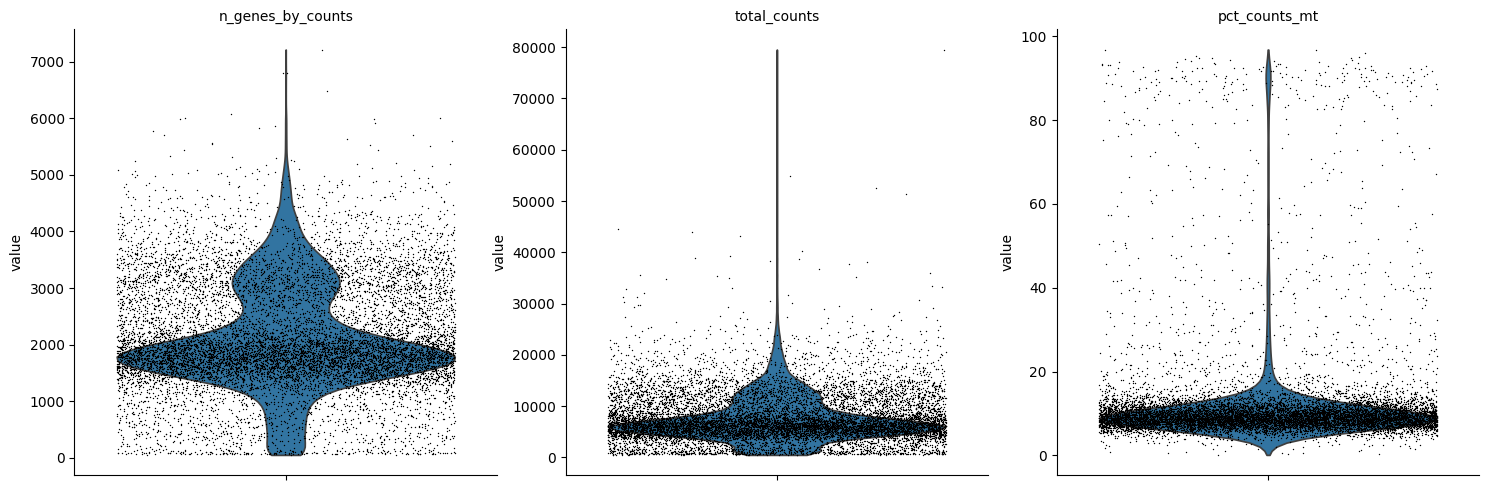

In [5]:
#Violin plot of QC metrics (from https://scverse-tutorials.readthedocs.io/en/latest/notebooks/basic-scrna-tutorial.html)
#the number of genes expressed in the count matrix
#the total counts per cell
#the percentage of counts in mitochondrial genes
sc.pl.violin(adClean, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

From the violin plots, we observe:
- Most cells express 1,500-5,000 genes
- Total UMI counts per cell range from 5,000-20,000
- Most cells have 10-20% mitochondrial content

Thus, I applied the following filters:
- Mitochondrial content < 20%: Higher percentages indicate dying/stressed cells
- Minimum 500 genes: Removes low-quality cells
- Maximum 30,000 UMI counts: Removes likely doublets
- Genes in $\geq$ 10 cells: Removes noise from rare transcripts

In [6]:
adClean = adClean[adClean.obs['pct_counts_mt']<20,:].copy()
adClean.var_names_make_unique()
sc.pp.filter_cells(adClean, min_genes=500)
sc.pp.filter_cells(adClean, max_counts=30000)
sc.pp.filter_genes(adClean, min_cells=10)

### Normalization

We normalize the data to make cells comparable. Library size normalization accounts for differences in capture effeciency between cells, and log transformation stabilizes variance across expression levels.

In [7]:
adNorm = adClean.copy()
#proportion of reads for a gene relative to total library size 
sc.pp.normalize_total(adNorm , target_sum=1e4)
sc.pp.log1p(adNorm)
#store log-normalized data in a new layer
adNorm.layers['lognorm'] = adNorm.X.copy()

<a id='question-1'></a>
# 1. What cell types are present in the data and in what proportions?

To identify cell types, I focused on highly variable genes (HVGs), genes that show high variance (heteroskedasticity) across cells. These genes are most informative for distinguishing different cell populations, while housekeeping genes that are expressed similarly across all cells contribute little discriminatory power.

In [8]:
n_hvg = 2000
sc.pp.highly_variable_genes(adNorm, n_top_genes=n_hvg, flavor='cell_ranger')

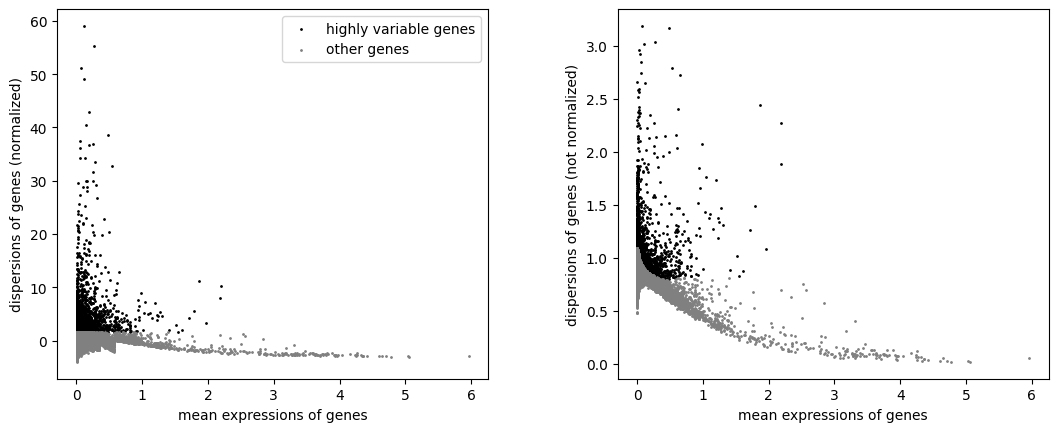

In [9]:
sc.pl.highly_variable_genes(adNorm)

### Pipeline for identifying cell types:

1. PCA
     - Many genes are correlated in their expression patterns, so there is redundancy in the data.
     - Allows us to capture the variance in the data, instead of the whole genome, making it computationally less exhausting

2. k-Nearest Neighbors
     - creates an adjacency matrix by finding, for each cell, the k cells that are closest to it.
     - encodes the local structure of the data, which becomes the backbone of both UMAP and Leiden clustering.

3. UMAP
     - Reduce the dimensions to 2D from the kNN

4. Leiden Clustering.
     - Resolution: 0.5 for more finer clusers (to identify subtypes)

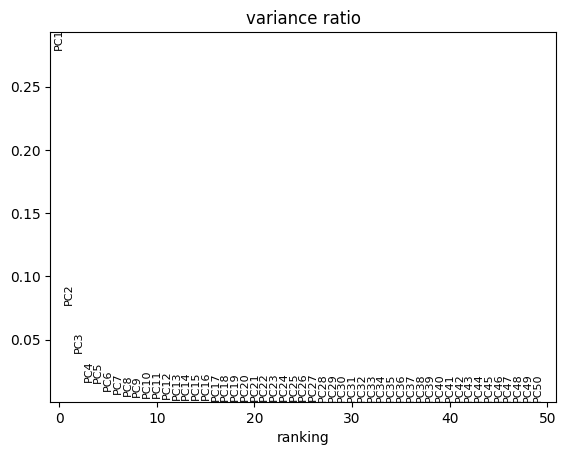

In [10]:
#dimensional reduction on only genes that are highly variable
sc.tl.pca(adNorm , mask_var='highly_variable')
sc.pl.pca_variance_ratio(adNorm, 50)

#### PCA Variance Analysis¶
The PCA variance plot shows that PC1 explains approximately 30% of the variance in our data. The variance explained by each PC drops off significantly after PC10, suggesting that 10 PCs capture most of the meaningful variation in the dataset.

In [11]:
#number of neighbors
n_neighbors = 20
#number of PCs to use (used 10 as that is where most of the varience is explained)
n_pcs = 10
#k‑nearest‑neighbor graph on first 10 PC and 20 neighbors
sc.pp.neighbors(adNorm, n_neighbors=n_neighbors, n_pcs=n_pcs, random_state=0)

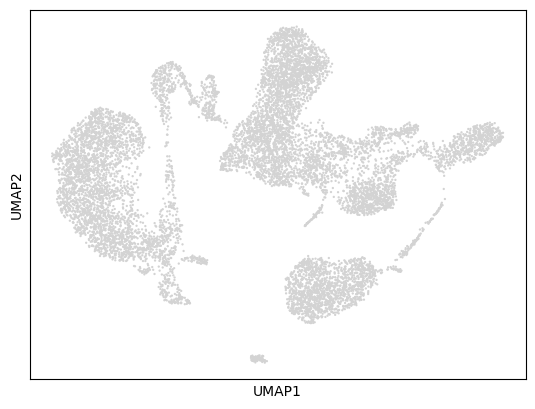

In [12]:
#UMAP uses the neighbor graph to place each cell/spot in 2D space
sc.tl.umap(adNorm, random_state=0)
#printing out the unclustered umap
sc.pl.umap(adNorm)

In [13]:
#increased the resolution to 0.5 to find sub-cell types
sc.tl.leiden(adNorm, resolution=0.5, flavor='igraph', n_iterations=2, key_added='leiden_cluster')

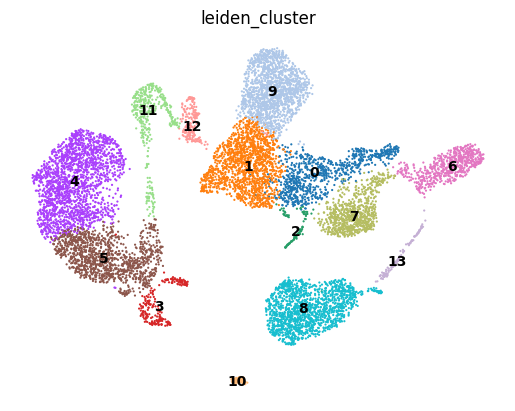

In [14]:
sc.pl.umap(adNorm, color=['leiden_cluster'], legend_loc='on data', size=10, frameon=False)

### Marker genes 
These marker genes were taken from the HW. The information was originally from:

Sen, P., Kemppainen, E., & Orešič, M. (2018). Perspectives on Systems Modeling of Human Peripheral Blood Mononuclear Cells. Frontiers in molecular biosciences, 4, 96. https://doi.org/10.3389/fmolb.2017.00096)

Monocyte: LYZ (Lysozyme), CD14, CD68

    Sub-types:
        - Classical: CD14, LYZ, S100A8/S100A9, CCR2
        - Intermediate: FCGR3A (CD16), CD163, IL1B
        - non-classical: CX3CR1, FCGR3A (CD16), CCR5
Natural killer cell: NCAM1 , KIR2DL1, KIR2DL3, KIR2DL4, KIR3DL1, KIR3DL2, NKG2A/C/E (KLRC1/KLRC2/KLRC3), NKG2D (KLRK1), GNLY, GZMB

*Note that some NK genes are also expressed by subsets of T cell*

B cell: CD19, CD79A, CD79B, CD20

T cell: CD3D, CD3E, CD3G


Dendritic cell: FLT3, CD11C CD1C

Plasmacytoid dendritic Cell: CD123 & CLEC4C

Granulocytes and Megakaryocytes: Not widely recognized as occurring in PBMC.

##### Some of the gene data was from:

Palmer, C., Diehn, M., Alizadeh, A.A. et al. Cell-type specific gene expression profiles of leukocytes in human peripheral blood. BMC Genomics 7, 115 (2006). https://doi.org/10.1186/1471-2164-7-115


In [15]:
#dictionary for the number of genes 
marker_genes = {'CD14 Monocyte': ['CD14', 'LYZ', 'S100A8', 'S100A9', 'CCR2'],
                'CD14 CD16 Monocyte': ['CD14','CD163', 'IL1B', 'FCGR3A'],
                'CD16 Monocyte': ['CX3CR1', 'CCR5', 'FCGR3A'],
                'Pan T cell': ['CD3D', 'CD3E', 'CD3G'],
                'CD4 T cell': ['CD4', 'GATA3'],
                'CD8 T cell': ['CD8A', 'CD8B', 'EOMES', 'KLRG1'],
                #MS4A1 codes for CD20
                'B cell': ['CD19', 'CD79A', 'CD79B', 'MS4A1'],
                'NK cell': ['GNLY', 'NKG7'],
                'DC': ['FLT3', 'CD1C'],
                #CD123 is IL3RA
                'pDC': ['IL3RA', 'CLEC4C']}

categories: 0, 1, 2, etc.
var_group_labels: CD14 Monocyte, CD14 CD16 Monocyte, CD16 Monocyte, etc.


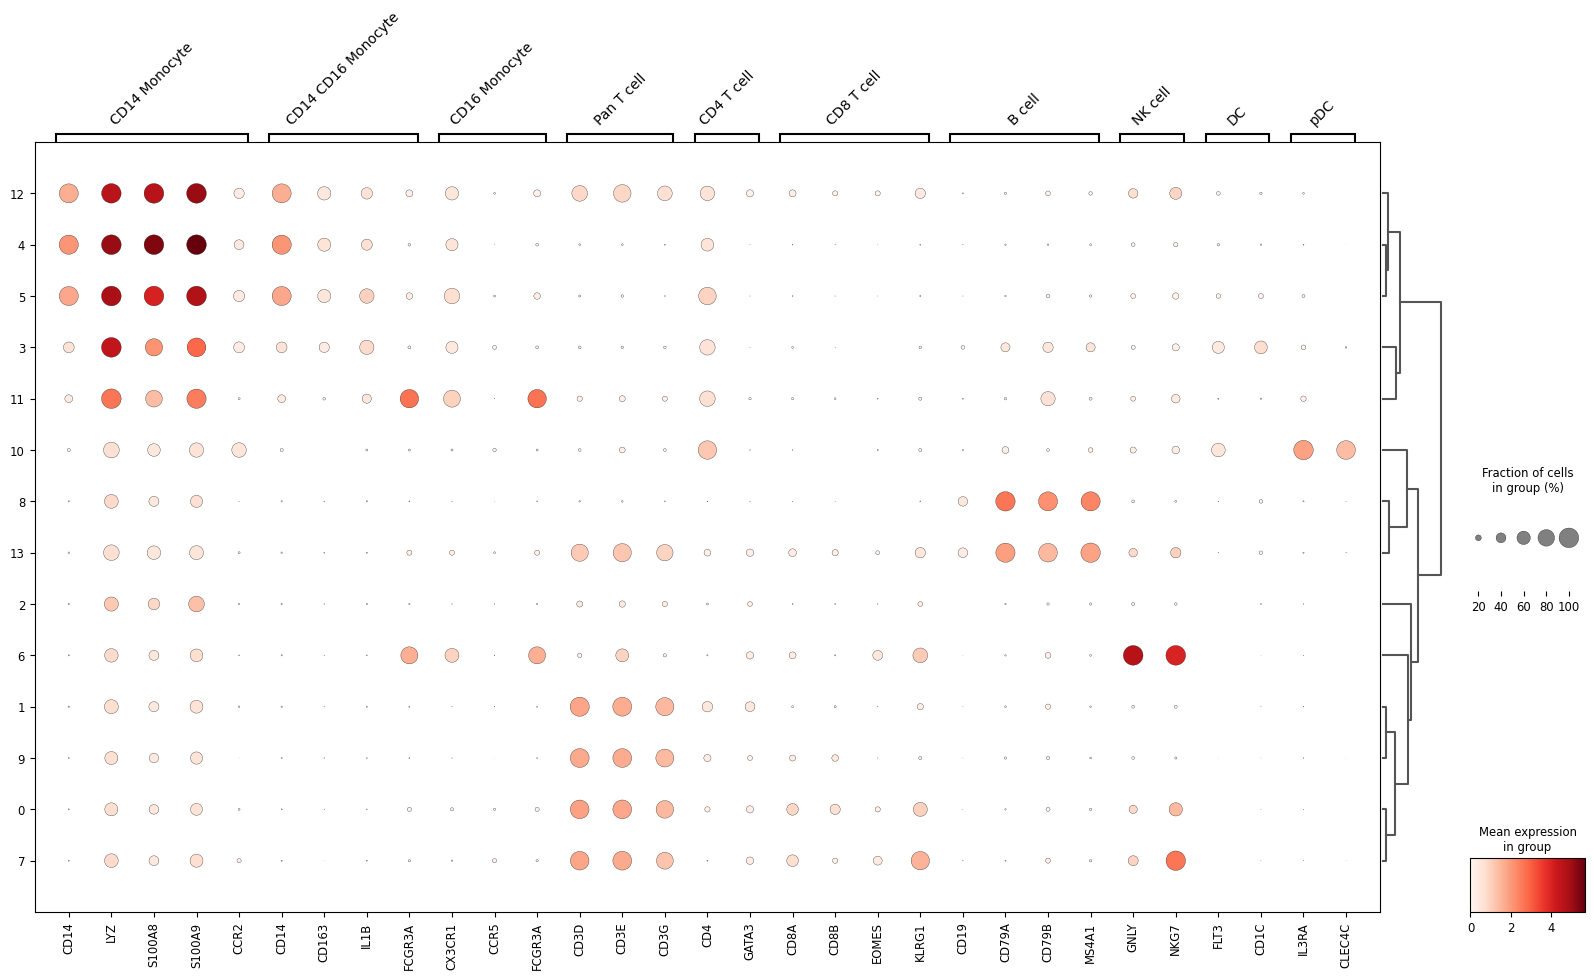

In [16]:
sc.tl.dendrogram(adNorm, groupby='leiden_cluster')
#plot the dotplot to see if marker genes are expressd
#helps to identify what cell type is in the cluster
sc.pl.dotplot(adNorm, marker_genes, groupby='leiden_cluster', dendrogram=True, 
              var_group_rotation=45, figsize=(20, 10))

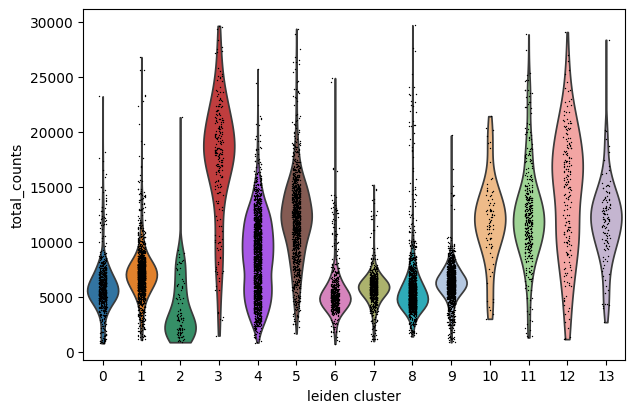

In [17]:
#violin plot to see the distribution of total gene expression per cluster
sc.pl.violin(adNorm, ['total_counts'], groupby='leiden_cluster' )

#### Doublet identification

Clusters 0, 1, 6, 7, 8: ~5,000-8,000 counts 

Cluster 3 (red, median: ~20,000 counts):
- ~3-4x higher than typical single cells
  
Cluster 12 (pink, median: ~20,000 counts):
- also has elevated counts compared to most clusters (but has more variance than cluster 3)

Clusters 3 and 12 show elevated UMI counts (median ~20,000) compared to typical  single cells (5,000-8,000), suggesting they are doublets. Cluster 3 expresses both monocyte and DC markers, while cluster 12 expresses T cell and monocyte markers. This implies that clusters 3 and 12 are most likely doublets. These will be removed from downstream analysis.

In [18]:
cluster_to_celltype = {'0':'CD8 T cell',   
                       '1':'CD4 T cell',      
                       '2': 'Unknown', 
                       '3': 'Mono/DC doublet',
                       '4': 'CD14 Monocyte',
                       '5': 'CD14 Monocyte',
                       '6': 'NK cell',                   
                       '7': 'CD8 T cell',      
                       '8': 'B cell', 
                       '9': 'Pan T cell',          
                       '10':'pDC',    
                       '11':'CD16 Monocyte', 
                       '12': 'T/Mono doublet', 
                       '13': 'B cell'}       

### Cell Type Annotation Rationale

CD8 T cells (Clusters 0, 7): Express pan-T cell markers (CD3D, CD3E, CD3G) plus CD8-specific markers (CD8A, CD8B, KLRG1)

CD4 T cells (Cluster 1): Express pan-T cell markers (CD3D, CD3E, CD3G) with CD4 and GATA3 expression

Pan T cells (Cluster 9): High expression of pan-T cell markers (CD3D, CD3E, CD3G) but without clear CD4 or CD8 differentiation

B cells (Clusters 8, 13): High expression of B cell markers (CD19, CD79A, CD79B, MS4A1/CD20)

NK cells (Cluster 6): High GNLY and NKG7 expression without T cell markers

CD14 Monocytes (Clusters 4, 5): Classical monocyte markers (CD14, LYZ, S100A8, S100A9, CCR2)

CD16 Monocytes (Cluster 11): High FCGR3A (CD16) expression with low CD14

Plasmacytoid Dendritic Cells/pDC (Cluster 10): Highest expression of IL3RA (CD123) and CLEC4C

Unknown (Cluster 2): Low gene count for most things.

Mono/DC doublet (Cluster 3): Expresses both monocyte markers and DC markers (FLT3, CD1C); likely monocyte-derived DC doublets. Shows elevated UMI counts (~20,000) consistent with doublet identity.

T/Mono doublet (Cluster 12): Co-expresses T cell markers (CD3D/E/G) and CD14 monocyte markers; positioned between T cell and monocyte clusters in UMAP. Elevated UMI counts (~20,000) confirm doublet status.

categories: 0, 1, 2, etc.
var_group_labels: 2


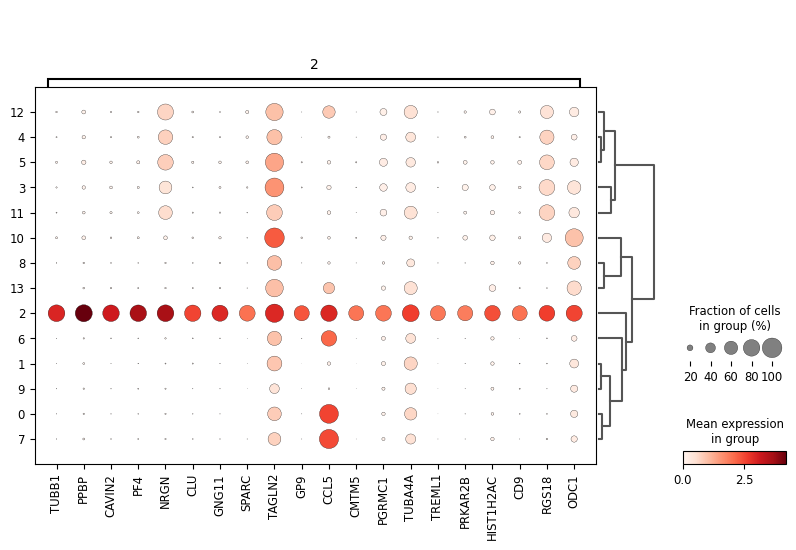

In [19]:
#differential expression analysis between clusters
sc.tl.rank_genes_groups(adNorm, use_raw=False, groupby='leiden_cluster')
#we see that the highest genes in this cluster are TUBB1, PPBP, CAVIN2, PF4, NRGN, and CLU compared to other clusters
sc.pl.rank_genes_groups_dotplot(adNorm, n_genes=20, groupby='leiden_cluster', dendrogram=True, key='rank_genes_groups', groups=['2'])

We see from Supernat, A., Popęda, M., Pastuszak, K. et al. Transcriptomic landscape of blood platelets in healthy donors. Sci Rep 11, 15679 (2021). https://doi.org/10.1038/s41598-021-94003-z that these are most likely platelets cells. 

In [20]:
#relabel the unknown group as platelets
cluster_to_celltype = {'0':'CD8 T cell',   
                       '1':'CD4 T cell',      
                       '2': 'Platelets', 
                       '3': 'Mono/DC doublet',
                       '4': 'CD14 Monocyte',
                       '5': 'CD14 Monocyte',
                       '6': 'NK cell',                   
                       '7': 'CD8 T cell',      
                       '8': 'B cell', 
                       '9': 'Pan T cell',          
                       '10':'pDC',    
                       '11':'CD16 Monocyte', 
                       '12': 'T/Mono doublet', 
                       '13': 'B cell'}       

In [21]:
#add cell type annotation in the adata object
adNorm.obs['cell_type'] = adNorm.obs['leiden_cluster'].map(cluster_to_celltype)

#for any unmapped clusters, assign as 'Unknown'
adNorm.obs['cell_type'] = adNorm.obs['cell_type'].fillna('Unknown')

print('\nCell type composition:')
print(adNorm.obs['cell_type'].value_counts())


Cell type composition:
cell_type
CD14 Monocyte      3127
B cell             1602
CD8 T cell         1577
Pan T cell         1517
CD4 T cell         1447
NK cell             616
CD16 Monocyte       399
Mono/DC doublet     223
T/Mono doublet      198
Platelets           104
pDC                  81
Name: count, dtype: int64


In [22]:
adNorm

AnnData object with n_obs × n_vars = 10891 × 17422
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'n_counts', 'leiden_cluster', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden_cluster', 'leiden_cluster_colors', 'dendrogram_leiden_cluster', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'lognorm'
    obsp: 'distances', 'connectivities'

### Data visualization

1. UMAP: shows spatial organization of cell types
2. Dotplot: confirm marker gene expression patterns

categories: B cell, CD4 T cell, CD8 T cell, etc.
var_group_labels: CD14 Monocyte, CD14 CD16 Monocyte, CD16 Monocyte, etc.


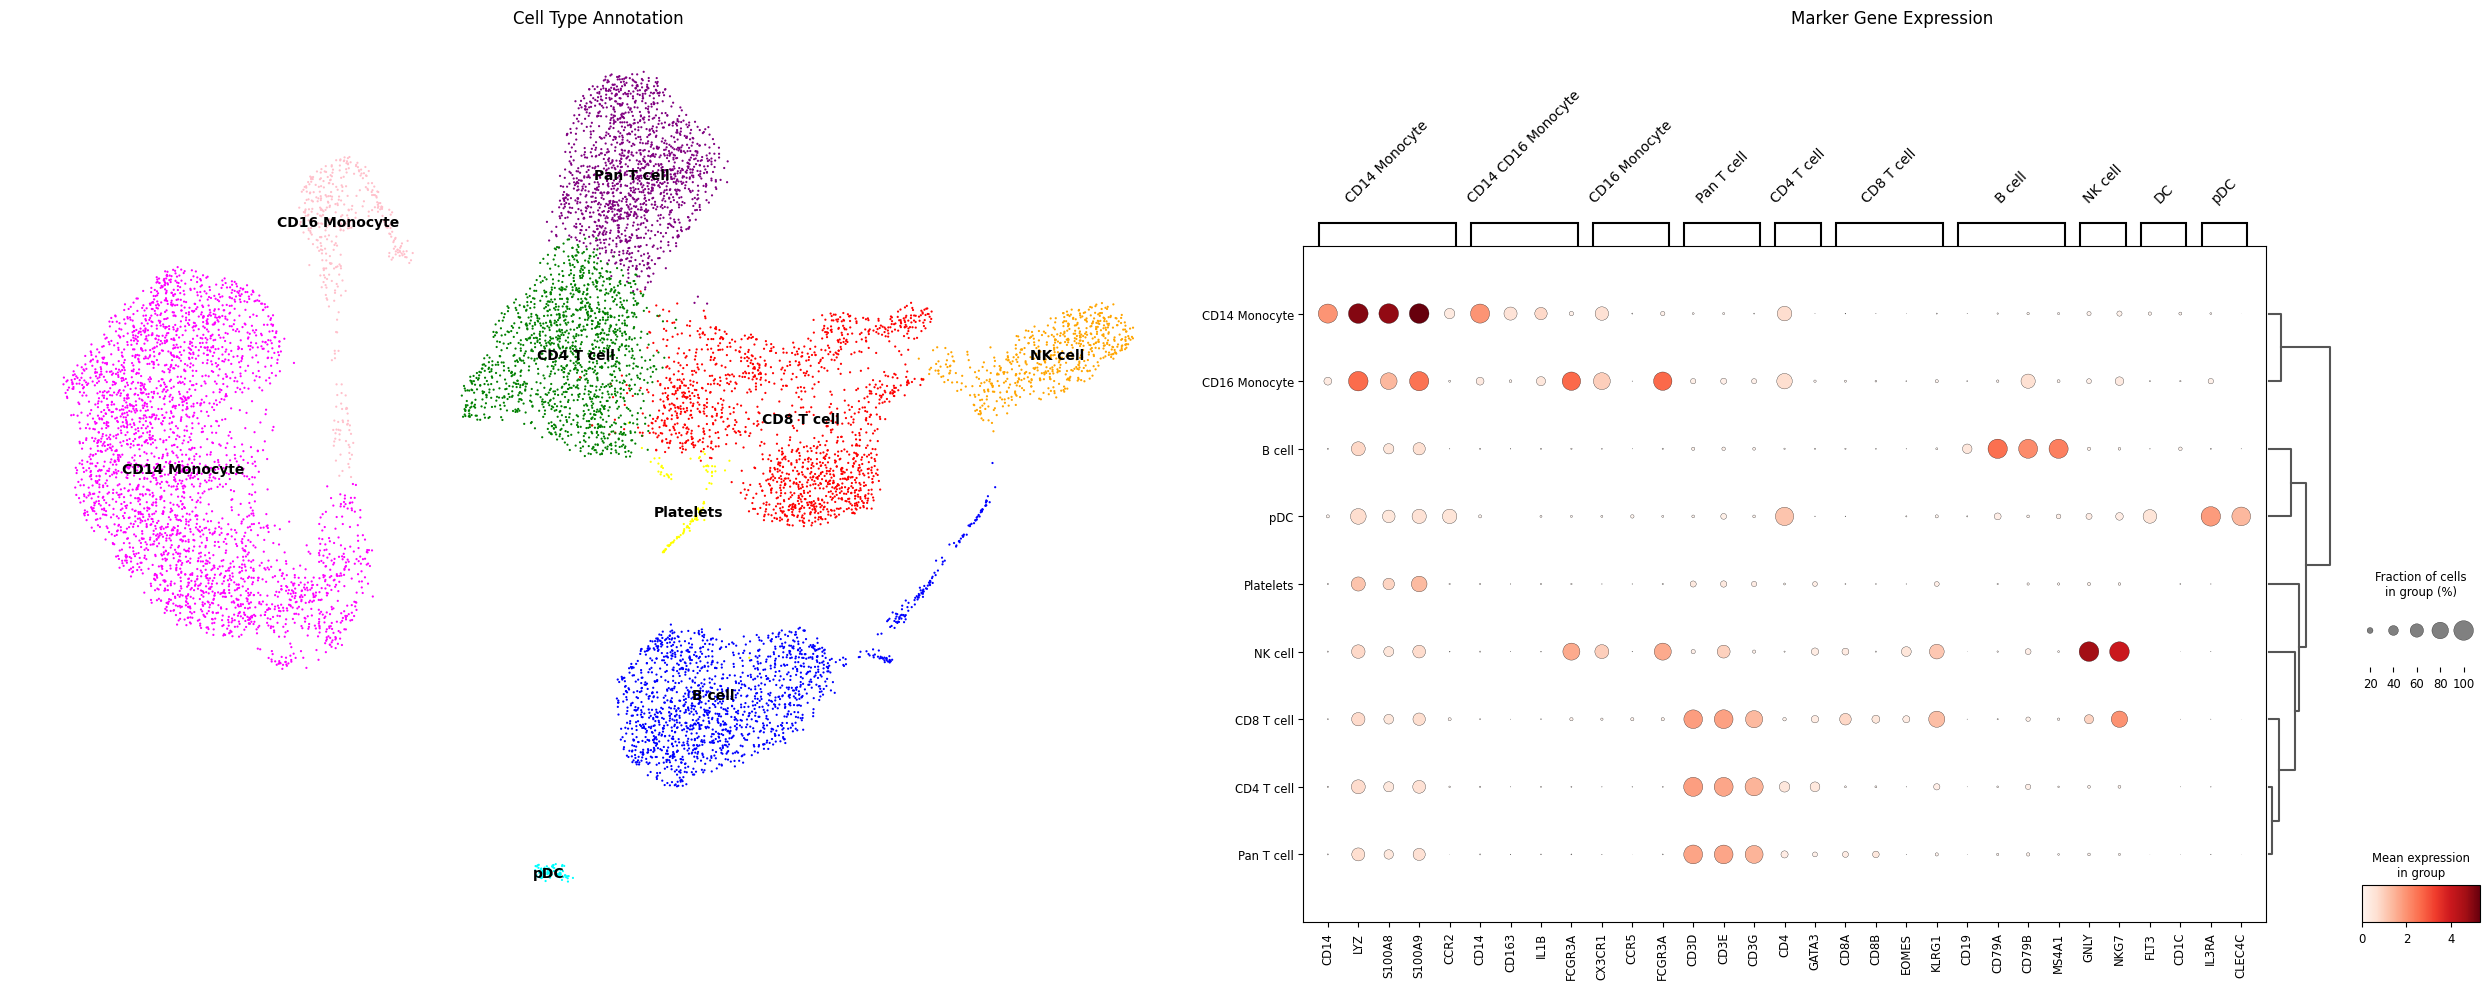

In [23]:
cell_type_colors = {'B cell': 'Blue',
                    'NK cell': 'Orange',
                    'CD4 T cell':'Green',
                    'CD8 T cell' :'Red',
                    'Pan T cell': 'Purple',
                    'CD14 Monocyte':'Magenta',
                    'T/Mono doublet':'Olive',
                    'CD16 Monocyte': 'Pink',
                    'Mono/DC doublet':'Black',
                    'pDC': 'Cyan',
                    'Platelets': 'Yellow'}

#remove the doublet clusters from the total count
doublet_labels = ['T/Mono doublet', 'Mono/DC doublet']
adNorm_clean = adNorm[~adNorm.obs['cell_type'].isin(doublet_labels)].copy()

#plot annotated UMAP and dotplot
fig, axes = plt.subplots(1, 2, figsize=(25, 10))

#UMAP with cell types
sc.pl.umap(adNorm_clean, color='cell_type', palette=cell_type_colors, 
           size=10, frameon=False, legend_loc='on data', ax=axes[0], show=False)
axes[0].set_title('Cell Type Annotation')
#plot dotplot with marker gene expression
sc.pl.dotplot(adNorm_clean, marker_genes, groupby='cell_type', 
              dendrogram=True, var_group_rotation=45, ax=axes[1], show=False)
axes[1].set_title('Marker Gene Expression')

plt.tight_layout()
plt.show()

<a id='question-2'></a>
# How does this estimate of cell composition compare to prior literature?

To evaluate our scRNA-seq results against published PBMC composition, I compared the observed proportions to literature values using a stacked barplot.

In [24]:
#calculate proportions
cell_counts = adNorm_clean.obs['cell_type'].value_counts()
total_cells = cell_counts.sum()
cell_proportions = (cell_counts / total_cells * 100).round(2)

print('\nCell type proportions (%):')
for cell_type, prop in cell_proportions.items():
    print(f'{cell_type}: {prop}%')


Cell type proportions (%):
CD14 Monocyte: 29.87%
B cell: 15.3%
CD8 T cell: 15.06%
Pan T cell: 14.49%
CD4 T cell: 13.82%
NK cell: 5.88%
CD16 Monocyte: 3.81%
Platelets: 0.99%
pDC: 0.77%


In [25]:
#literature proportions (from the homework)
literature_proportions = {'T cell': 70.0, 
                          'B cell': 15.0,
                          'NK cell': 10.0,
                          'Monocyte': 5.0,  
                          'Dendritic cell': 1.0,
                          'Platelets': 0.0}
#combining the subtypes into one cluster
proportions_combined = {'T cell': cell_proportions.get('CD4 T cell', 0) + cell_proportions.get('CD8 T cell', 0) + cell_proportions.get('Pan T cell', 0),
                        'B cell': cell_proportions.get('B cell', 0),
                        'NK cell': cell_proportions.get('NK cell', 0),
                        'Monocyte': cell_proportions.get('CD14 Monocyte', 0) + cell_proportions.get('CD16 Monocyte', 0),
                        'Dendritic cell': cell_proportions.get('pDC', 0),
                        'Platelets': cell_proportions.get('Platelets', 0),}
#placing the values in a dataframe for easy plotting
proportion_df = pd.DataFrame({'scRNA-seq': proportions_combined,
                              'Literature': literature_proportions}).T 

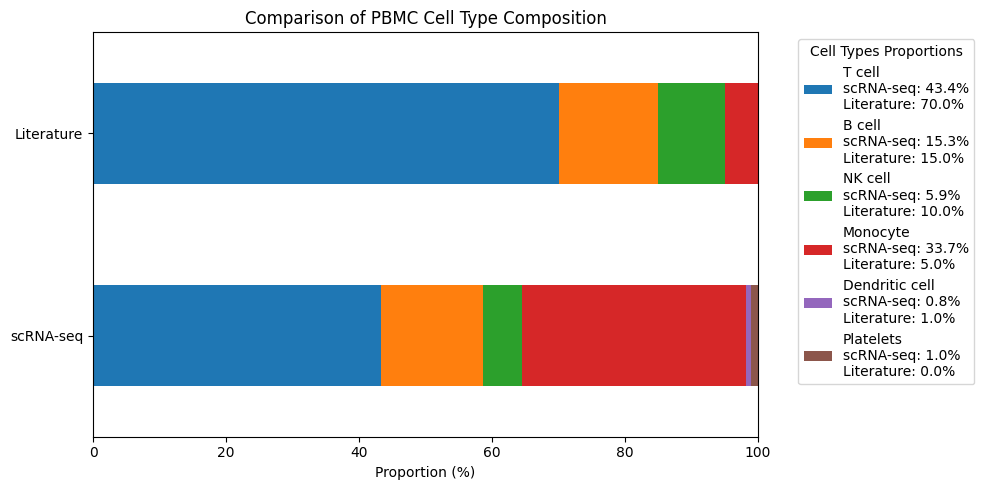

In [26]:
#horizontal stacked barplot
proportion_df.plot(kind='barh', stacked=True, figsize=(10, 5))
plt.title('Comparison of PBMC Cell Type Composition')
plt.xlabel('Proportion (%)')
plt.xticks(rotation=0)
plt.xlim(0,100)

legend_labels = []
for cat in proportion_df.columns:
    my_val = proportion_df.loc['scRNA-seq', cat]
    lit_val = proportion_df.loc['Literature', cat]
    legend_labels.append(f'{cat}\nscRNA-seq: {my_val:.1f}%\nLiterature: {lit_val:.1f}%')

plt.legend(legend_labels, title='Cell Types Proportions', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

### Comparison to Literature Values

Our scRNA-seq analysis shows notable differences from expected PBMC composition:

#### Major Discrepancies

T cells: 41.7% (observed) vs 70.0% (literature)
- Significantly fewer T cells than expected
- This represents about a 40% reduction from literature values
- Possible explanations: donor-specific variation, processing effects, doublet removal, differences in capture efficiency, etc

Monocytes: 32.4% (observed) vs 5.0% (literature)
- Monocytes are 6.5x more abundant
- This is the biggest difference in the dataset
- Possible explanations: donor-specific variation, recent immune activation, capture efficiency, etc.

NK cells: 5.7% (observed) vs 10.0% (literature)
- Slightly lower than expected (43% reduction)

Platelets: 0.9% (observed) vs 0.0% (literature)
- Platelets are not typically considered PBMCs
- Their presence likely reflects incomplete removal during sample processing

#### Close Matches

B cells: 14.7% (observed) vs 15.0% (literature)
- Nearly identical to literature values
- Suggests B cell identification and isolation were accurate

Dendritic cells: 0.7% (observed) vs 1.0% (literature)
- Close match, both representing rare cell types
- Nearly all identified DCs are plasmacytoid DCs (pDCs) rather than conventional DCs (cDCs)
- The absence of cDCs and presence of only pDCs might be due to the challenges in distinguishing cDCs from monocytes (doublet cluster removal)


<a id='question-3'></a>
# What are the transcriptional signatures of each of the PBMC cell types? 

To identify genes that define each cell type, differential expression analysis was used to compare each cell type against all others. Iapplied the filtered from Patrick Cahan's notbeook. 

- minimum fold change $\geq$ 0.7 for genes must show substantial upregulation
- genes must be expressed in $\geq$ 50% of cells within the group to ensure they are consistently expressed
- genes must be expressed in $\leq$ 15% of cells outside the group for specificity

These criteria identify genes that are both highly expressed and specific to each cell type, combining known markers with novel discoveries.

In [27]:
sc.tl.rank_genes_groups(adNorm_clean, groupby='cell_type', use_raw=False)

#filter for significant genes
sc.tl.filter_rank_genes_groups(adNorm_clean, min_fold_change=.7, min_in_group_fraction=.5, max_out_group_fraction=.15)

#get top marker genes for each cell type
n_top_genes = 10
signature_genes = {}

for cell_type in adNorm_clean.obs['cell_type'].cat.categories:
        #get top genes for this cell type
        de_results = sc.get.rank_genes_groups_df(adNorm_clean, group=cell_type)
        de_results = de_results[de_results['pvals_adj'] < 0.05]
        #store top genes
        top_genes = de_results.head(n_top_genes)['names'].tolist()
        signature_genes[cell_type] = top_genes
        print(f'\nTop {n_top_genes} signature genes for {cell_type}:')
        print(', '.join(top_genes))


Top 10 signature genes for B cell:
CD79A, CD74, MS4A1, HLA-DRA, HLA-DPA1, CD79B, CD37, HLA-DPB1, HLA-DRB1, IGHM

Top 10 signature genes for CD4 T cell:
TRAC, CD3D, IL32, LDHB, LTB, IL7R, CD3E, RPS18, RPS29, CD3G

Top 10 signature genes for CD8 T cell:
CCL5, IL32, CD3D, CD3E, GZMA, GZMK, LYAR, TRAC, KLRG1, CTSW

Top 10 signature genes for CD14 Monocyte:
LYZ, S100A9, FCN1, MNDA, S100A8, CST3, CTSS, VCAN, TYROBP, FTL

Top 10 signature genes for CD16 Monocyte:
AIF1, TYROBP, COTL1, FCER1G, LST1, CTSS, FTL, CST3, FTH1, PSAP

Top 10 signature genes for NK cell:
GNLY, NKG7, CTSW, KLRD1, GZMA, PRF1, CST7, KLRF1, HOPX, CD247

Top 10 signature genes for Pan T cell:
RPS12, RPS3A, RPL32, RPS27, RPS27A, RPL13, RPL30, RPS6, RPS3, RPL36

Top 10 signature genes for Platelets:
TUBB1, PPBP, CAVIN2, PF4, NRGN, CLU, GNG11, SPARC, TAGLN2, GP9

Top 10 signature genes for pDC:
IRF8, CD74, JCHAIN, GZMB, CCDC50, TCF4, PLD4, UGCG, PLAC8, NPC2


I plugged these lists into a LLM asking: "What do each of these genes do?"
These are the responses:

B cells:
- B cell receptor components (CD79A/B)
-  MHC-II molecules (HLA genes) for antigen presentation
- IGHM (immunoglobulin heavy chain mu) antigen recognition molecules of B cells

CD4 T cells:
- T cell receptor (TRAC)
- CD3 complex
- IL32 (inflammatory cytokine), IL7R (IL-7 receptor, critical for T cell homeostasis)

CD8 T cells:
- Granzymes (GZMA, GZMK) for cytotoxic function
- CCL5 (chemokine)
- CTSW (cathepsin W, involved in cytotoxicity)

CD14 Monocytes: 
- LYZ (lysozyme)
- S100A8/A9 (inflammatory proteins)
- FCN1 (ficolin-1, pattern recognition receptor)
- VCAN (versican, involved in inflammation)

CD16 Monocytes:
- AIF1 (allograft inflammatory factor 1)
- FCER1G (Fc receptor gamma chain)

NK cells:
- GNLY (granulysin)
- NKG7, PRF1 (perforin) for cytotoxicity
- KLRD1, KLRF1 (killer cell receptors)

Pan T cells: 
- Ribosomal proteins (RPS12, RPS3A, RPL32, RPS27, etc.)
- This cluster shows enrichment of ribosomal protein genes, which may represent actively translating/proliferating T cells

Platelets:
- PPBP (pro-platelet basic protein)
-  PF4 (platelet factor 4)
-   GP9 (glycoprotein IX)

pDCs:
- IRF8 and TCF4 are transcription factors essential for pDC development
- JCHAIN (joining chain) links IgA/IgM polymers
- PLD4 (phospholipase D4, involved in type I interferon response)

Thus, the 'newly' discovered genes seem to match the cell type function. 

### Visualization


1. Heatmap: expression of individual genes across individual cells, revealing cell-to-cell heterogeneity
2. Matrix plot: mean scaled expression per cell type for population-level patterns
3. Dot plot: Combines mean expression (color) with fraction of expressing cells (size), providing both intensity and prevalence information

For each cell type the genes displayed were:
- All known marker genes from the literature
- Top 5 newly discovered signature genes (marked with asterisks)

In [28]:
#create a dictionary with known markers and discovered signatures
all_signatures = {}
#dictionary to know which genes are known vs discovered
known_gene_flags = {}

for cell_type in signature_genes.keys():
    #combine all known markers with discovered signatures
    known_markers = []
    for marker_cat, genes in marker_genes.items():
        #check if the current cell type matches the marker category 
        #works for for both exact matches and partial matches
        if cell_type.lower() in marker_cat.lower() or marker_cat.lower() in cell_type.lower():
            known_markers.extend([g for g in genes if g in adNorm.var_names])

    #take the first 5 new signature genes not in the known markers
    sig_genes= signature_genes.get(cell_type, [])
    new_sig_genes = [g for g in sig_genes if g not in known_markers]
    top_new = new_sig_genes[:5]

    #combine: all known markers + 5 new DEGs
    combined = list(dict.fromkeys(known_markers + top_new))
    all_signatures[cell_type] = combined

    #track known vs discovered
    known_gene_flags[cell_type] = ['known' if g in known_markers else 'discovered' for g in combined]

In [29]:
#flatten signatures into real + display lists
genes_real = [] #the gene name in the adata file
genes_display = [] #list that * discovered genes
group_labels = [] #cluster labels 
group_positions = [] #start and end of a gene list or a cluster 

start = 0
for cell_type in all_signatures:
    genes = all_signatures[cell_type]
    n = len(genes)
    #record group label
    group_labels.append(cell_type)
    #record group boundaries (start, end)
    group_positions.append((start, start + n - 1))
    #append genes (has a * if it was discover)
    for gene, flag in zip(genes, known_gene_flags[cell_type]):
        genes_real.append(gene)
        genes_display.append(gene + '*' if flag == 'discovered' else gene)
    start += n

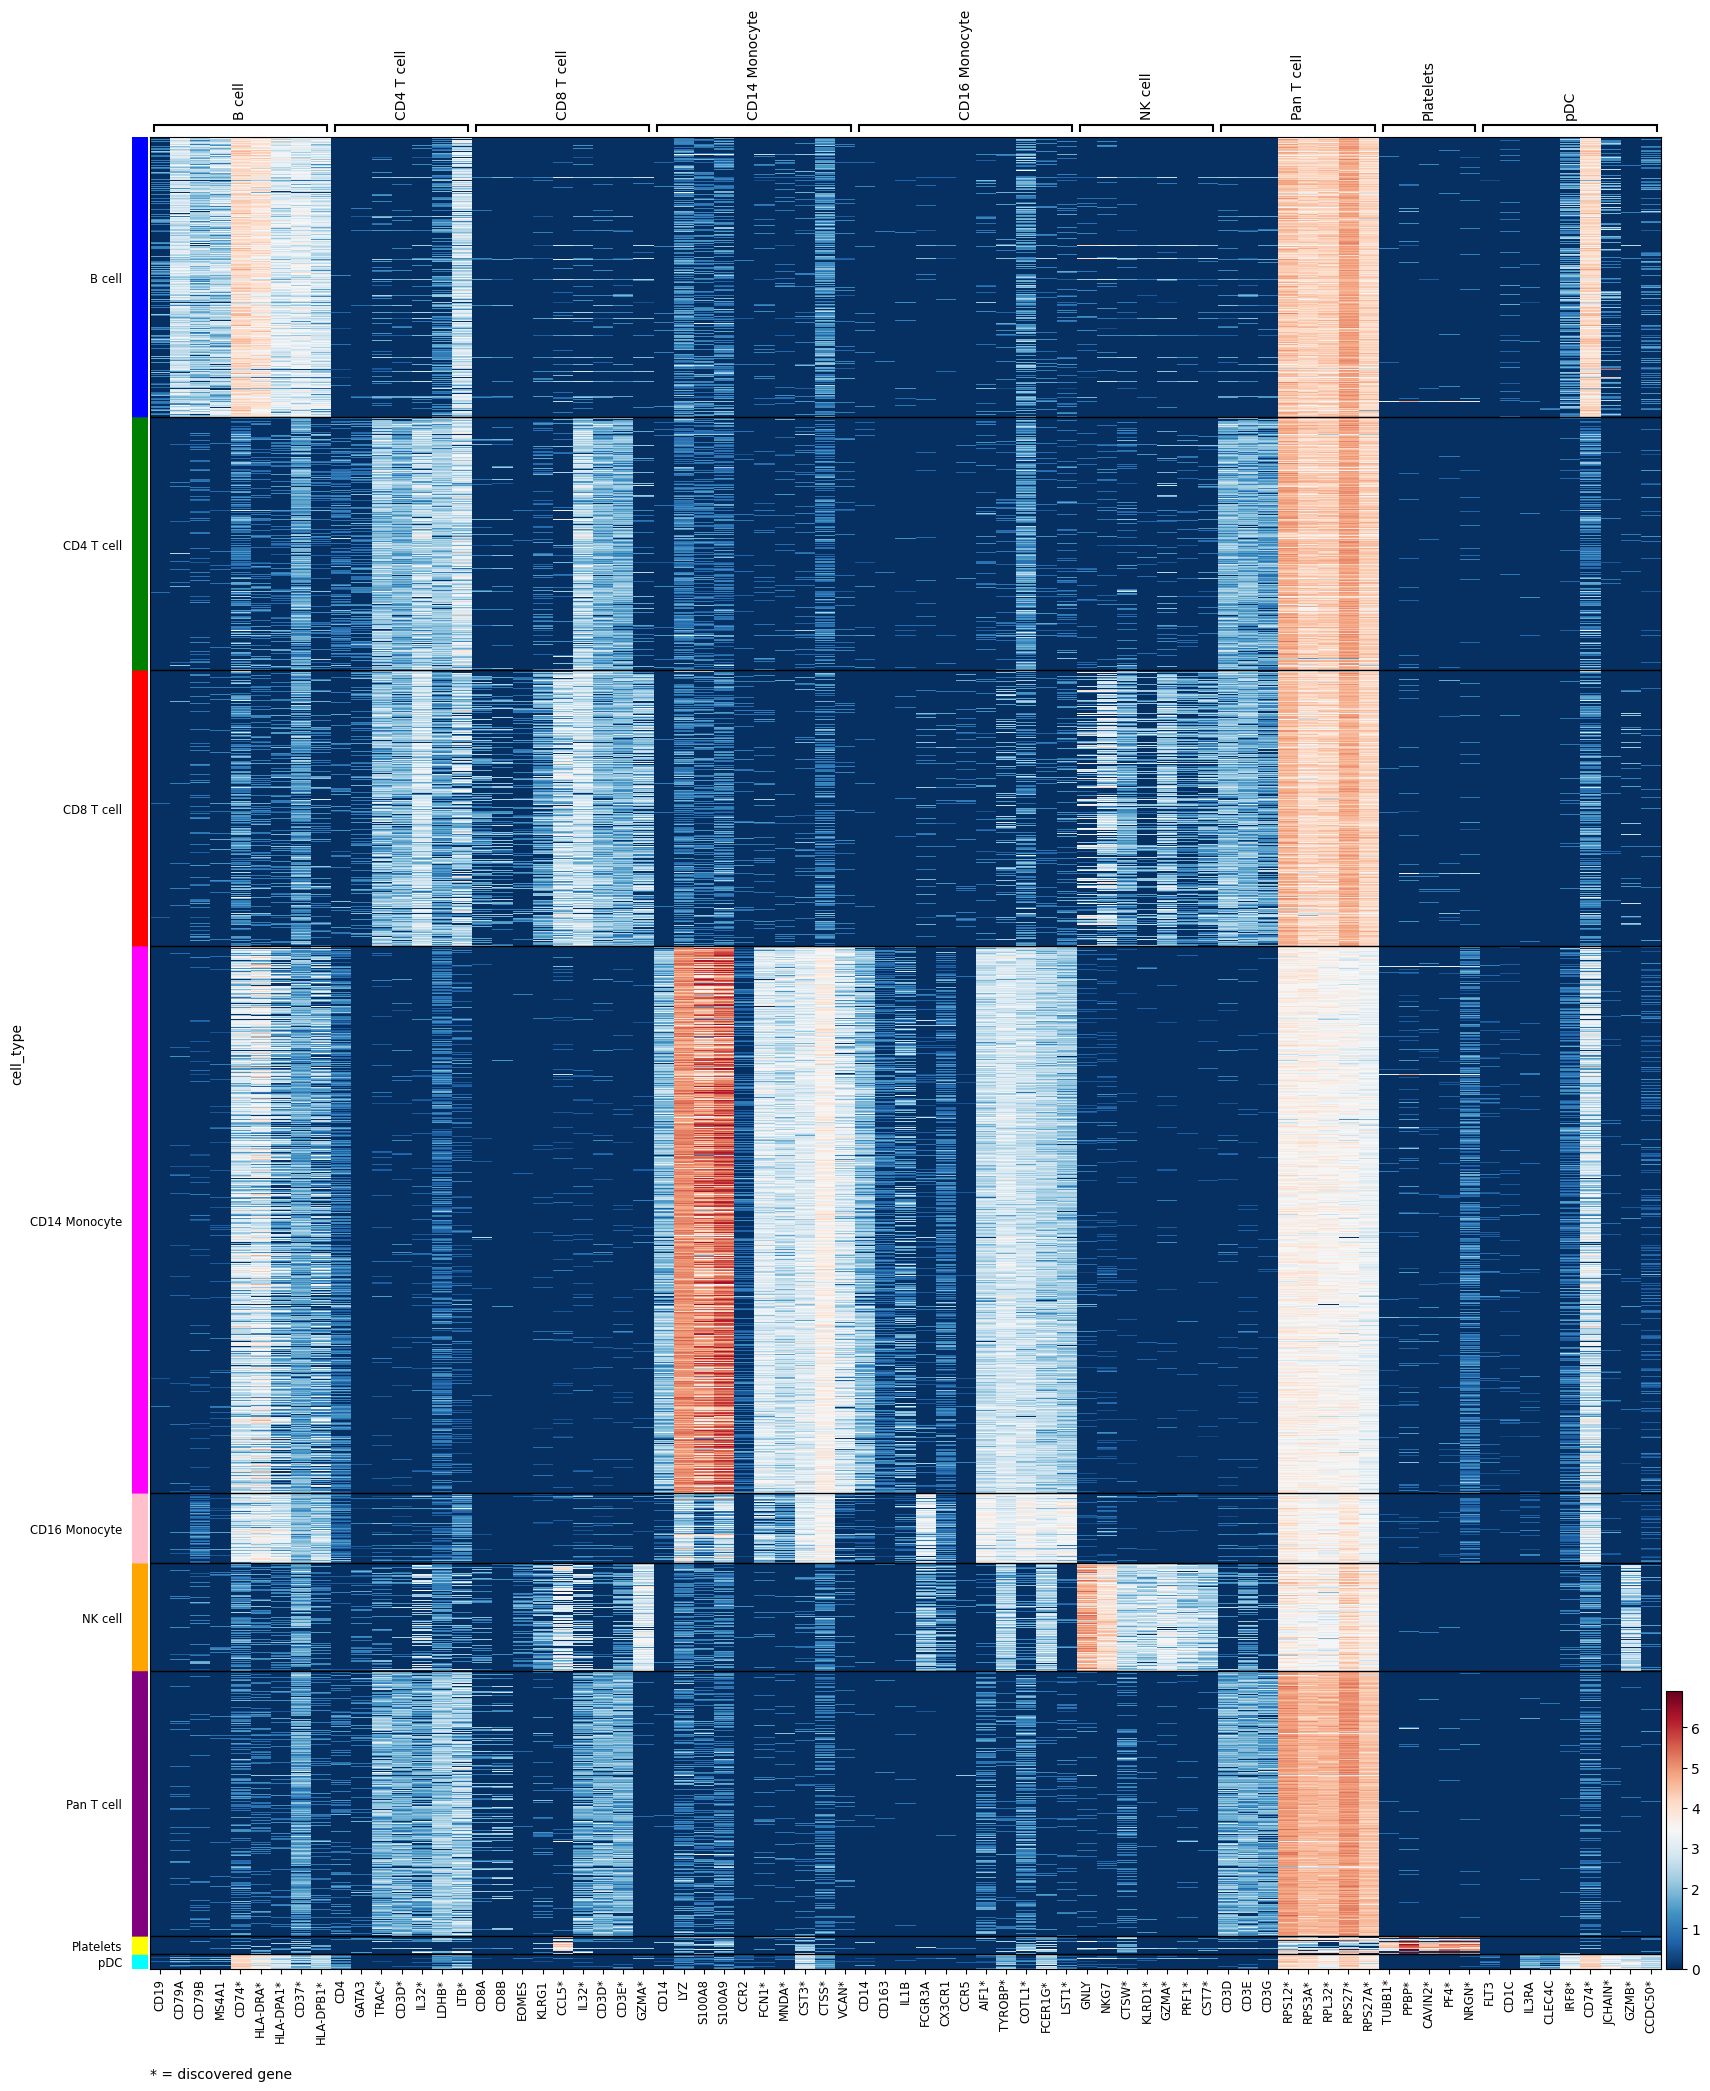

In [30]:
#plot heatmap
hm = sc.pl.heatmap(adNorm_clean,
                   var_names=genes_real,
                   groupby='cell_type',
                   figsize=(20, 24),
                   var_group_labels=group_labels,
                   var_group_positions=group_positions,
                   show_gene_labels=True,
                   cmap='RdBu_r',
                   show=False)
#edited the x-axis to asterisk newly discovered genes
ax = hm['heatmap_ax']
ax.set_xticklabels(genes_display) 
plt.text(0, -170,'* = discovered gene', transform=plt.gca().transAxes, fontsize=10)
plt.show()

In the heatmap, red indicates higher expression and blue indicates lower expression at the cell level. There are blocks of red/white along the diagonal of each gene group:

- B cell genes are mostly red in the B cell row and mostly blue elsewhere. 

- CD4 T cell genes are white in CD4 T cells (and in some CD8 and Pan T-cells) and mostly blue everywhere else.

- CD8 T cell genes are white in CD8 T cells. They are express in NK cells, which makes sense as cytotoxic NK cells express similar genes to CD8 T cells. Also, in the HW: "Some NK genes are also expressed by subsets of T cell".

- CD14 monocyte genes are strongest in CD14 monocytes (red compared to the other groups)

- CD16 monocyte genes are strongest in CD16 monocytes (white and red), but it appears that CD14 also expresses some of those genes. 

- NK genes are highest in NK cells.

- Pan T cells genes seem to be expressed in B cells, CD4, and CD8. This makes sense as CD4 and CD8 are subsets of Pan T cells. 

- Platelet genes are almost exclusively high in the platelet cluster.

- pDC genes seem to mostly be expressed in pDC, but B cells seem to express CD74 as well. 

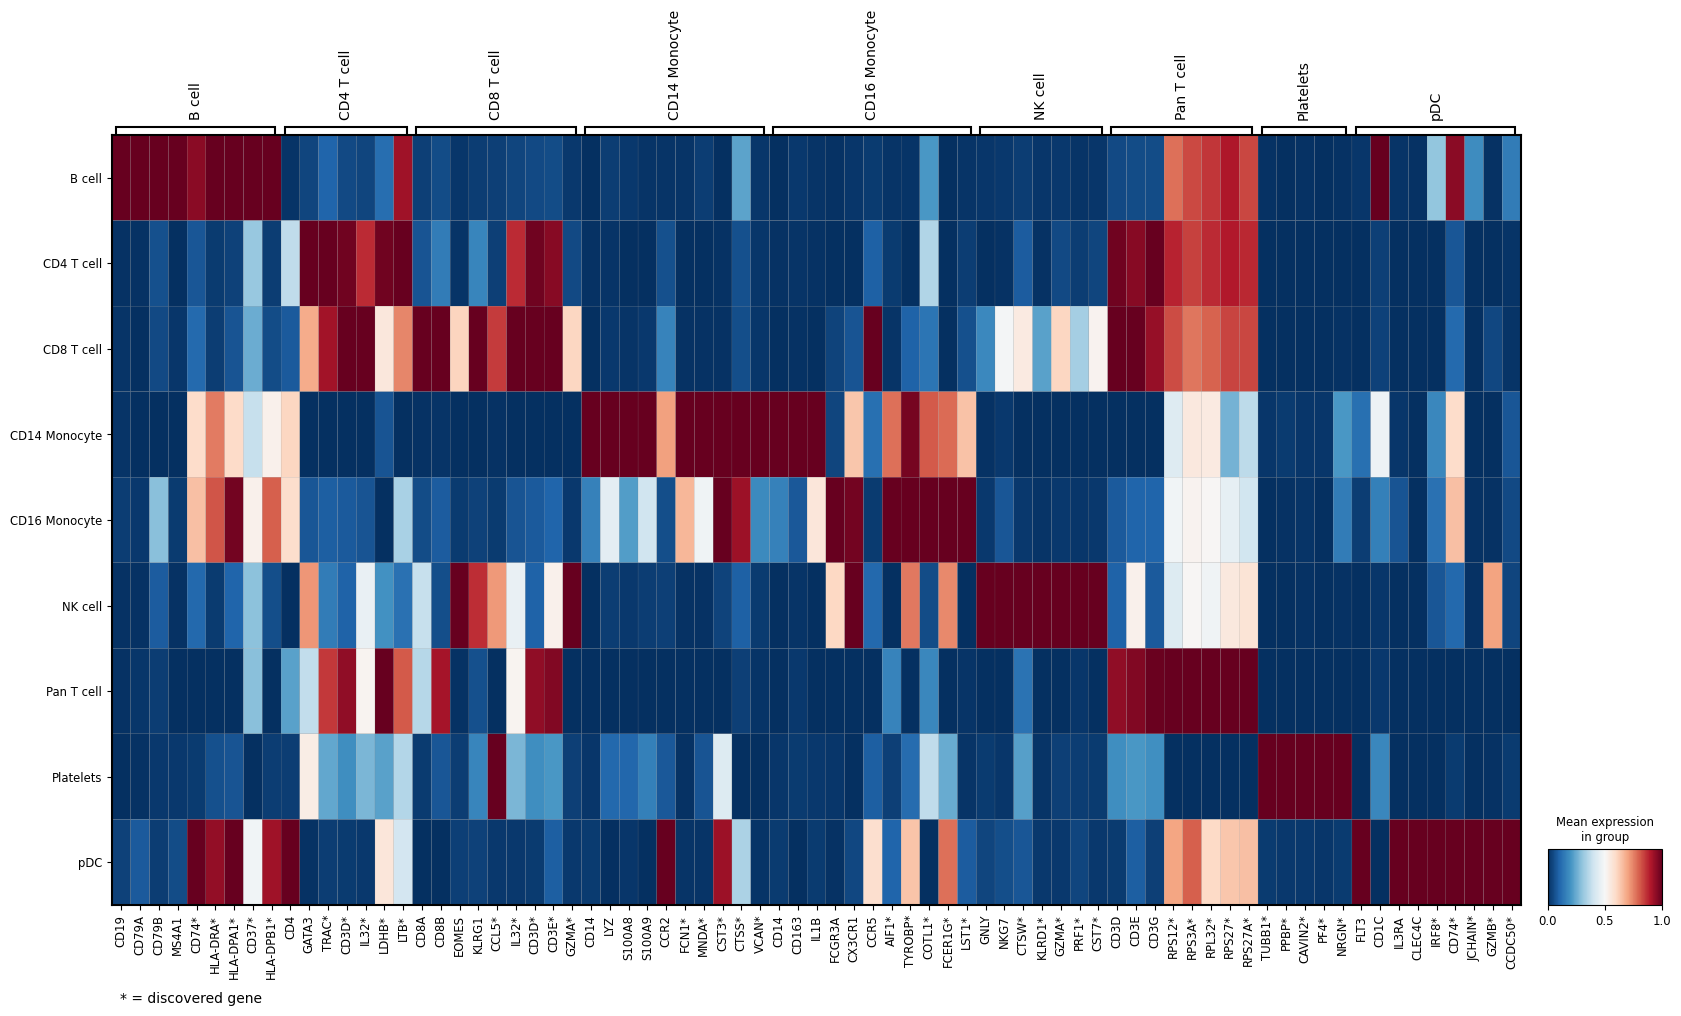

In [31]:
#plot matrix plot 
mat= sc.pl.matrixplot(adNorm_clean, 
                      var_names=genes_real,
                      groupby='cell_type', 
                      figsize=(20, 10),
                      var_group_labels=group_labels,
                      var_group_positions=group_positions,
                      cmap='RdBu_r',
                      standard_scale='var',
                      show=False)
ax = mat['gene_group_ax']
ax.set_xticklabels(genes_display) 
plt.text(-12.5, -1.75,'* = discovered gene', transform=plt.gca().transAxes, fontsize=10)
plt.show()

The matrix plot shows the average scaled expression of each gene in each cell type. It removes per-cell variability and focuses on mean expression. Clear vertical stripes of red color in a single row indicate that a gene is highly specific to one cell type. We can also see the diagonal is mostly red, while everywhere else is mostly blue (except for the Pan, CD4, and CD8, which express many Pan T cell genes). This plot emphasizes specificity of markers at the population level.

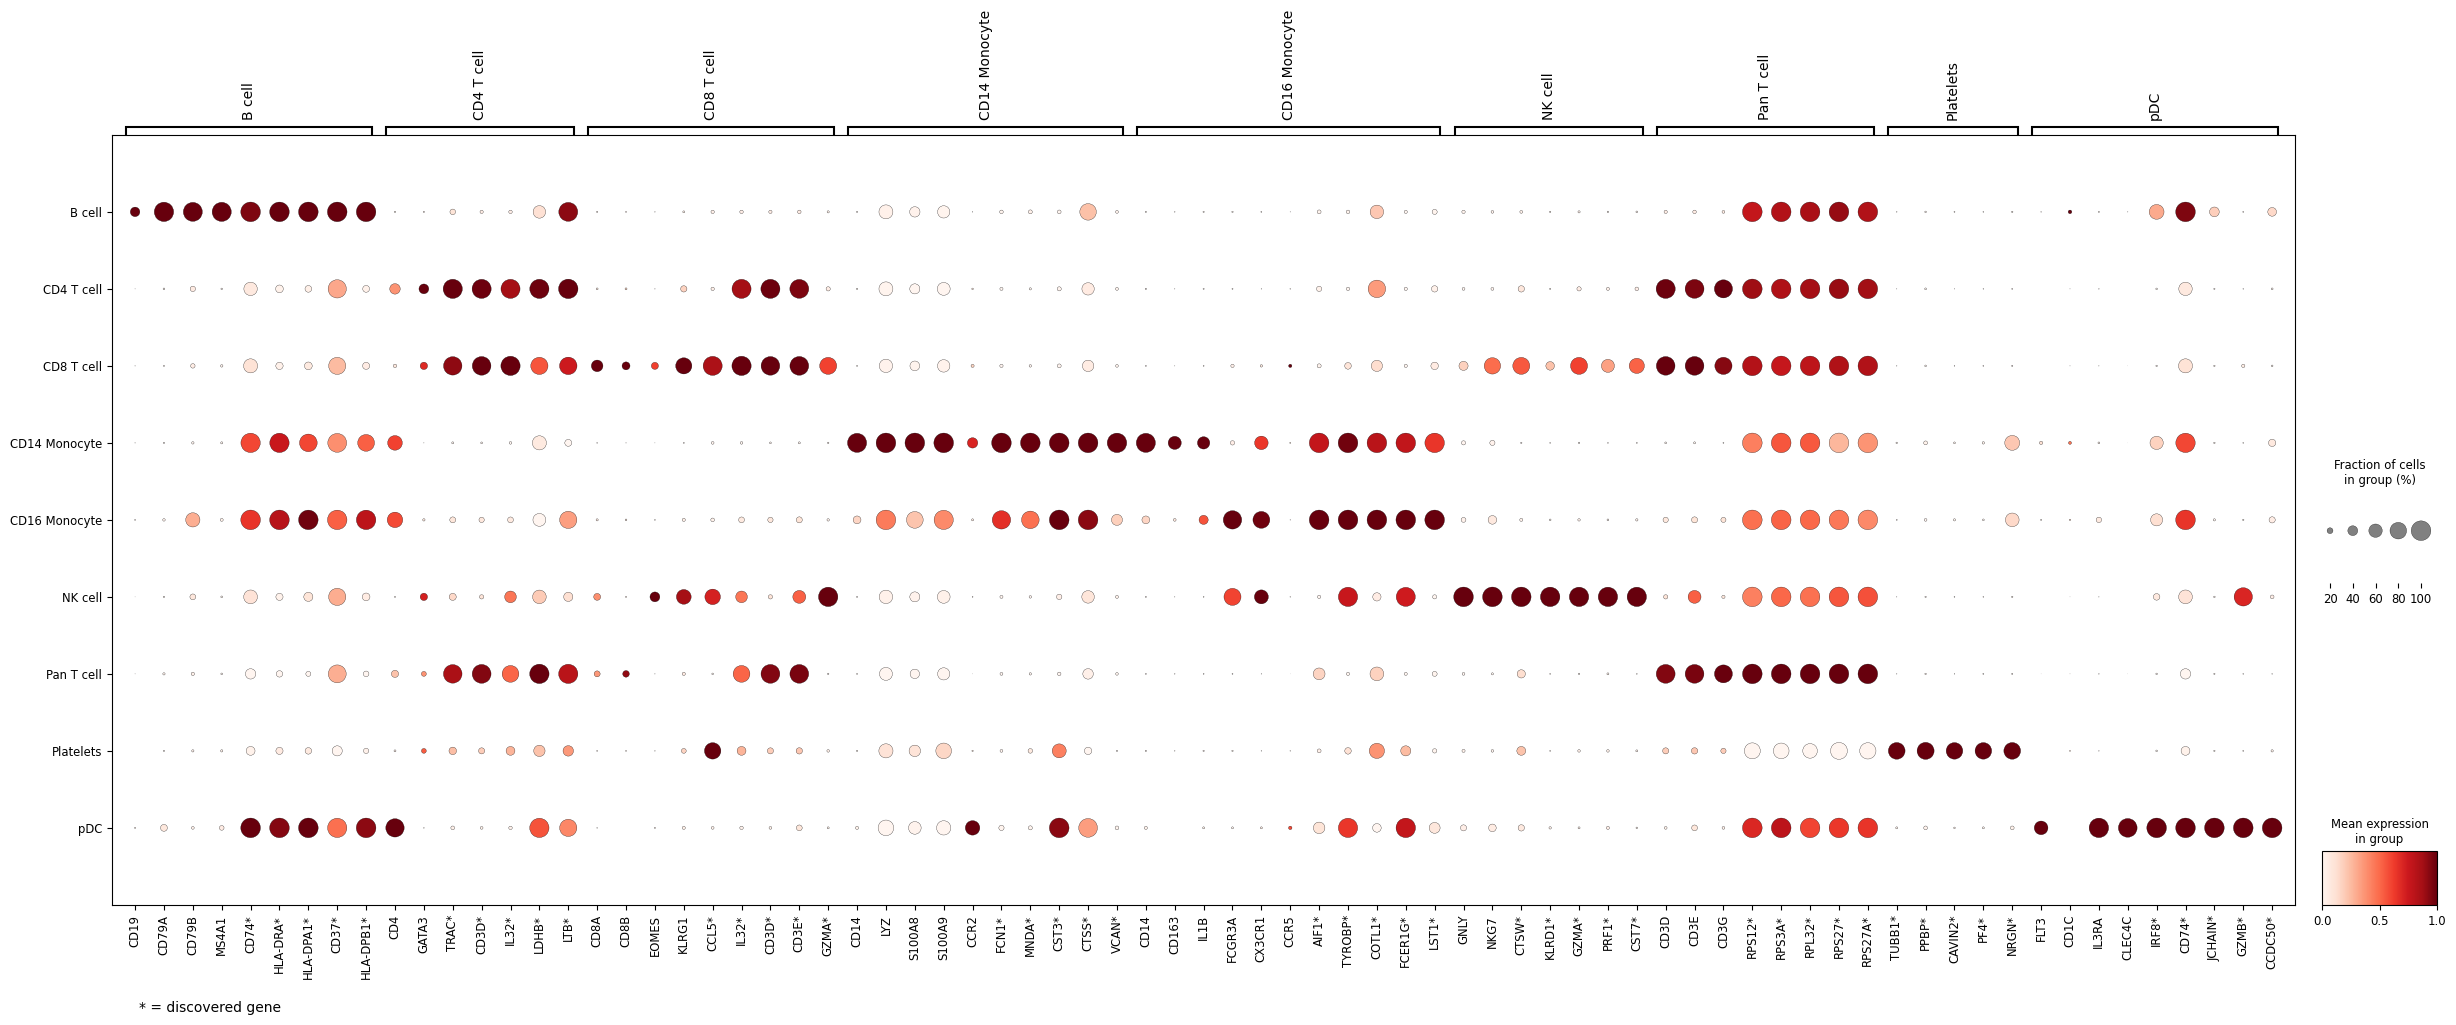

In [32]:
#plot dotplot 
dot = sc.pl.dotplot(adNorm_clean,
                    var_names=genes_real,
                    groupby='cell_type',
                    figsize=(30, 10),
                    var_group_labels=group_labels,
                    var_group_positions=group_positions,
                    var_group_rotation=90,
                    standard_scale='var',
                    cmap='Reds', 
                    show=False)
ax = dot['gene_group_ax']
ax.set_xticklabels(genes_display) 
plt.text(-19, -2,'* = discovered gene', transform=plt.gca().transAxes, fontsize=10)
plt.show()

In the dotplot, the dot color is the average expression level in that cell type, while dot size is the fraction of cells in that cell type expressing the gene. Large, dark-red dots mean most cells in this cluster express this gene at high levels. Small dots mean few cells express it, while pale dots means the genes is expressed at low levels. For example, B cell markers show large, dark dots only in the B cell row, so nearly all B cells express them.  Platelet markers show large dots only in the platelet cluster, confirming that cluster 2 is a distinct platelet population.